### Import required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from typing import Type, List
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN, MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize, RandomApply, ColorJitter, RandomRotation

### Define BasicBlock

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out



### Define ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block: Type[BasicBlock], layers: List[int], num_classes: int = 10, img_channels: int = 3, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_rate=0.0):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample, dropout_rate=dropout_rate)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


### Base transformation - DataAug

In [ ]:
transform_svhn = Compose([
    RandomApply([ColorJitter(brightness=0.5, contrast=0.5)], p=0.3),
    RandomRotation(degrees=15),
    ToTensor(),
    Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1201, 0.1231, 0.1052])
])


transform_mnist = Compose([
    Resize((32, 32)),
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=[0.1307, 0.1307, 0.1307], std=[0.3015, 0.3015, 0.3015])
])

### loading the dataset

In [ ]:
# SVHN: Loading Training and Test Sets
train_dataset_svhn = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
test_dataset_svhn = SVHN(root='./data', split='test', download=True, transform=transform_svhn)

train_loader_svhn = DataLoader(dataset=train_dataset_svhn, batch_size=16, shuffle=True, num_workers=2)
test_loader_svhn = DataLoader(dataset=test_dataset_svhn, batch_size=16, shuffle=False, num_workers=2)

# MNIST: Loading Training and Test Sets
train_dataset_mnist = MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=16, shuffle=True, num_workers=2)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=16, shuffle=False, num_workers=2)

print("Data loaders have been created.")

100%|██████████| 182040794/182040794 [00:03<00:00, 45901959.31it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 25271957.33it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 38274074.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49768156.87it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10190569.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9840149.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data loaders have been created.


### device - model - criterion ...

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=10, img_channels=3,  dropout_rate=0.5)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training definition

In [ ]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader_svhn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_svhn)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 2.2814
Epoch [2/10], Loss: 2.2124
Epoch [3/10], Loss: 1.1760
Epoch [4/10], Loss: 0.5398
Epoch [5/10], Loss: 0.4157
Epoch [6/10], Loss: 0.3591
Epoch [7/10], Loss: 0.3259
Epoch [8/10], Loss: 0.3016
Epoch [9/10], Loss: 0.2821
Epoch [10/10], Loss: 0.2673


### plotting the loss

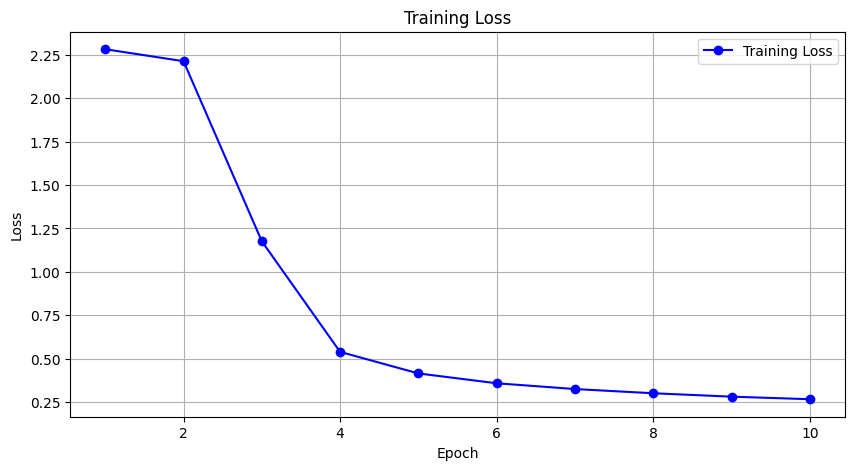

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', color='blue', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Define Test model

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

### Results

In [ ]:
accuracy_svhn = test_model(model, test_loader_svhn)
accuracy_mnist = test_model(model, test_loader_mnist)

Accuracy: 94.76%
Accuracy: 79.25%
